<a href="https://colab.research.google.com/github/AdityaGaur19/Algorithmic-Strategies-in-Real-World-Problems/blob/main/Algorithmic_Strategies_in_Real_World_Problem_Solving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 💻 Algorithmic Strategies in Real-World Problem Solving  
**Course:** Design and Analysis of Algorithms Lab (ENCA351)  
**Session:** 2025-26 | **Program:** BCA (AI & Data Science)  
**Student:** Aditya Gaur  
**Faculty:** Dr. Aarti Sangwan  
**Platform:** Google Colab  


In [9]:
# === Cell 0: Install & imports (run first) ===
!pip install -q memory_profiler pandas

import time
from memory_profiler import memory_usage
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os
import pandas as pd
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any

# create images and tables folders
os.makedirs("images", exist_ok=True)
os.makedirs("tables", exist_ok=True)

In [10]:
# === Cell 0.1: Utilities ===
def timed(func):
    def wrapper(*args, **kwargs):
        t0 = time.perf_counter()
        res = func(*args, **kwargs)
        t1 = time.perf_counter()
        return {"time": t1 - t0, "result": res}
    return wrapper

def mem_and_time(func, *args, **kwargs):
    baseline = memory_usage(proc=-1, interval=0.01, timeout=0.1)
    t0 = time.perf_counter()
    mem = memory_usage((func, args, kwargs), interval=0.01)
    t1 = time.perf_counter()
    peak = max(mem) - (baseline[0] if baseline else 0)
    return {"time": t1 - t0, "mem_mb": peak}

def save_and_show_plot(fig, filename="images/plot.png", dpi=150):
    fig.savefig(filename, bbox_inches="tight", dpi=dpi)
    plt.show()
    print(f"Saved -> {filename}")

def df_to_csv_and_display(df: pd.DataFrame, filename="tables/table.csv"):
    df.to_csv(filename, index=False)
    display(df)
    print(f"Saved table -> {filename}")

In [11]:
# === Cell 1.1: Ad dataclass ===
@dataclass
class Ad:
    id: str
    deadline: int
    profit: int

In [12]:
# === Cell 1.2: schedule_ads_greedy (returns slot table) ===
def schedule_ads_greedy(ads: List[Ad]) -> Dict[str, Any]:
    """
    Returns dict:
      - scheduled_slots: list where index 1..D holds Ad or None
      - scheduled_list: list of scheduled Ad in slot order
      - total_profit
      - slots_df: pandas DataFrame (slot, ad_id, profit)
    """
    if not ads:
        return {"scheduled_slots": [], "scheduled_list": [], "total_profit": 0, "slots_df": pd.DataFrame()}
    ads_sorted = sorted(ads, key=lambda x: x.profit, reverse=True)
    max_deadline = max(ad.deadline for ad in ads_sorted)
    slots = [None] * (max_deadline + 1)  # 1-indexed
    total_profit = 0
    for ad in ads_sorted:
        for s in range(min(max_deadline, ad.deadline), 0, -1):
            if slots[s] is None:
                slots[s] = ad
                total_profit += ad.profit
                break
    scheduled_list = [slot for slot in slots[1:] if slot is not None]
    # create DataFrame for slots
    rows = []
    for i in range(1, len(slots)):
        if slots[i] is None:
            rows.append({"slot": i, "ad_id": None, "profit": 0})
        else:
            rows.append({"slot": i, "ad_id": slots[i].id, "profit": slots[i].profit})
    slots_df = pd.DataFrame(rows)
    return {"scheduled_slots": slots, "scheduled_list": scheduled_list, "total_profit": total_profit, "slots_df": slots_df}

Total profit: 142
Profile -> time: 0.190873s, mem: 0.617 MB


,slot,ad_id,profit
0,1,C,27
1,2,A,100
2,3,E,15


Saved table -> tables/ads_slots_example.csv


,num_ads,total_revenue
0,10,468
1,50,1594
2,100,3549
3,200,7648
4,400,9542


Saved table -> tables/ads_vs_revenue_table.csv


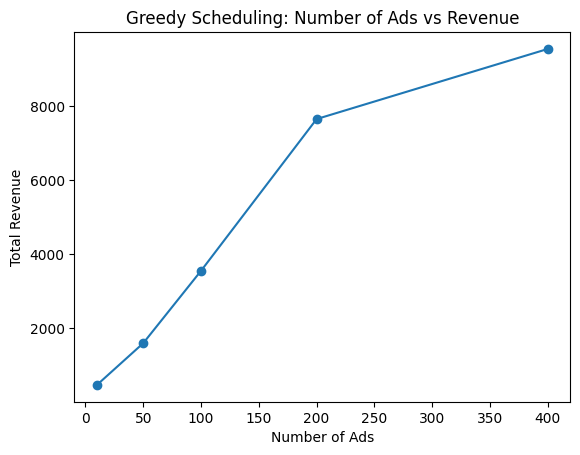

Saved -> images/ads_vs_revenue.png


In [13]:
# === Cell 1.3: TV scheduling example & profiling + table & plot ===
ads_example = [
    Ad("A", 2, 100),
    Ad("B", 1, 19),
    Ad("C", 2, 27),
    Ad("D", 1, 25),
    Ad("E", 3, 15),
]
prof = mem_and_time(lambda: schedule_ads_greedy(ads_example))
out = schedule_ads_greedy(ads_example)
print("Total profit:", out["total_profit"])
print("Profile -> time: {:.6f}s, mem: {:.3f} MB".format(prof["time"], prof["mem_mb"]))
# display slot table
df_to_csv_and_display(out["slots_df"], filename="tables/ads_slots_example.csv")

# simulate many n to build plot table
def simulate_ads_table(num_ads_list=[10,50,100,200,400]):
    rng = np.random.default_rng(42)
    results = []
    for n in num_ads_list:
        ads = []
        max_dead = max(2, min(n//5 + 2, 50))
        for i in range(n):
            d = int(rng.integers(1, max_dead))
            p = int(abs(rng.normal(100, 60))) + 1
            ads.append(Ad(str(i), d, p))
        out = schedule_ads_greedy(ads)
        results.append({"num_ads": n, "total_revenue": out["total_profit"]})
    df = pd.DataFrame(results)
    df_to_csv_and_display(df, filename="tables/ads_vs_revenue_table.csv")
    # plot
    fig, ax = plt.subplots()
    ax.plot(df["num_ads"], df["total_revenue"], marker='o')
    ax.set_xlabel("Number of Ads")
    ax.set_ylabel("Total Revenue")
    ax.set_title("Greedy Scheduling: Number of Ads vs Revenue")
    save_and_show_plot(fig, "images/ads_vs_revenue.png")

simulate_ads_table([10,50,100,200,400])

In [14]:
# === Cell 2.1: knapsack_01 with dp -> table ===
def knapsack_01(values: List[int], weights: List[int], capacity: int) -> Dict[str, Any]:
    n = len(values)
    dp = [[0] * (capacity + 1) for _ in range(n + 1)]
    for i in range(1, n+1):
        val = values[i-1]
        wt = weights[i-1]
        for w in range(capacity + 1):
            if wt <= w:
                dp[i][w] = max(dp[i-1][w], dp[i-1][w-wt] + val)
            else:
                dp[i][w] = dp[i-1][w]
    # reconstruct chosen
    chosen = []
    w = capacity
    for i in range(n, 0, -1):
        if dp[i][w] != dp[i-1][w]:
            chosen.append(i-1)
            w -= weights[i-1]
    chosen.reverse()
    # create dp-row summary table: capacity vs max_profit
    dp_summary = [{"capacity": c, "max_profit": dp[n][c]} for c in range(capacity+1)]
    dp_df = pd.DataFrame(dp_summary)
    return {"max_profit": dp[n][capacity], "chosen_items_idx": chosen, "dp": dp, "dp_df": dp_df}

Max profit: 220
Chosen indices: [1, 2]
Profile -> time: 0.139836s, mem: 0.000 MB


,capacity,max_profit
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


Saved table -> tables/knapsack_dp_example.csv


,capacity,time_s,mem_mb,max_profit
0,50,0.118287,0.023438,1081
1,90,0.050959,0.015625,1455
2,130,0.034122,0.039062,1657
3,170,0.035131,0.035156,1810
4,210,0.035483,0.050781,1935


Saved table -> tables/knapsack_capacity_results.csv


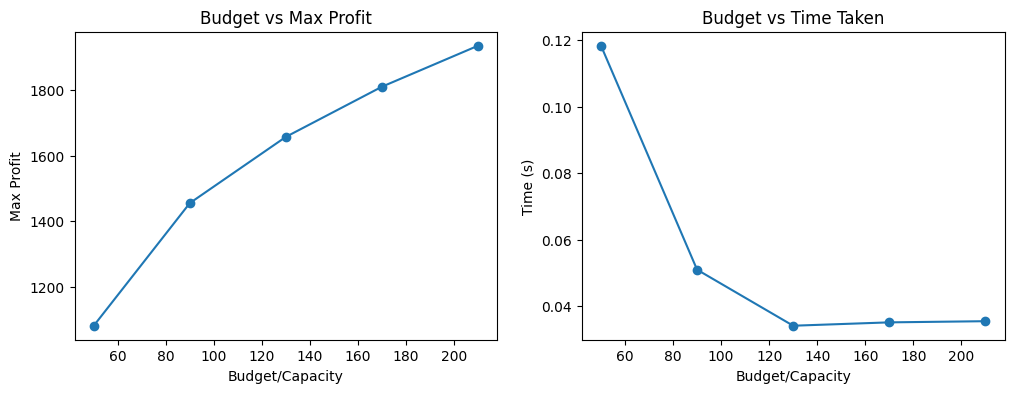

Saved -> images/knapsack_budget_profit.png


In [15]:
# === Cell 2.2: knapsack example & table + plotting ===
values = [60, 100, 120]
weights = [10, 20, 30]
capacity = 50
prof = mem_and_time(lambda: knapsack_01(values, weights, capacity))
res = knapsack_01(values, weights, capacity)
print("Max profit:", res["max_profit"])
print("Chosen indices:", res["chosen_items_idx"])
print("Profile -> time: {:.6f}s, mem: {:.3f} MB".format(prof["time"], prof["mem_mb"]))
# display dp table (capacity vs profit)
df_to_csv_and_display(res["dp_df"], filename="tables/knapsack_dp_example.csv")

# larger simulation: profit vs capacity and time vs capacity
def plot_profit_vs_budget(values, weights, capacities):
    rows = []
    times = []
    for c in capacities:
        mt = mem_and_time(lambda: knapsack_01(values, weights, c))
        times.append(mt["time"])
        rows.append({"capacity": c, "time_s": mt["time"], "mem_mb": mt["mem_mb"], "max_profit": knapsack_01(values, weights, c)["max_profit"]})
    df = pd.DataFrame(rows)
    df_to_csv_and_display(df, filename="tables/knapsack_capacity_results.csv")
    # plots
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].plot(df["capacity"], df["max_profit"], marker='o')
    ax[0].set_title("Budget vs Max Profit")
    ax[0].set_xlabel("Budget/Capacity")
    ax[0].set_ylabel("Max Profit")
    ax[1].plot(df["capacity"], df["time_s"], marker='o')
    ax[1].set_title("Budget vs Time Taken")
    ax[1].set_xlabel("Budget/Capacity")
    ax[1].set_ylabel("Time (s)")
    save_and_show_plot(fig, "images/knapsack_budget_profit.png")

# Demo with pseudo-random items (30)
rng = np.random.default_rng(1)
vals = [int(x) for x in rng.integers(10,200,size=30)]
wts = [int(x) for x in rng.integers(1,60,size=30)]
caps = list(range(50, 250, 40))
plot_profit_vs_budget(vals, wts, caps)

In [17]:
# === Cell 3.1: Sudoku helpers & board to DataFrame ===
def find_empty(board):
    for i in range(9):
        for j in range(9):
            if board[i][j] == 0:
                return i, j
    return None

def is_valid(board, row, col, num):
    if any(board[row][j] == num for j in range(9)):
        return False
    if any(board[i][col] == num for i in range(9)):
        return False
    br, bc = 3 * (row // 3), 3 * (col // 3)
    for i in range(br, br+3):
        for j in range(bc, bc+3):
            if board[i][j] == num:
                return False
    return True

def board_to_df(board):
    df = pd.DataFrame(board)
    df.index = [f"r{i+1}" for i in range(9)]
    df.columns = [f"c{j+1}" for j in range(9)]
    return df

In [18]:
# === Cell 3.2: solve_sudoku + profiling + save table ===
def solve_sudoku(board) -> Tuple[bool, List[List[int]]]:
    empty = find_empty(board)
    if not empty:
        return True, board
    r, c = empty
    for num in range(1, 10):
        if is_valid(board, r, c, num):
            board[r][c] = num
            solved, _ = solve_sudoku(board)
            if solved:
                return True, board
            board[r][c] = 0
    return False, board

# example
sample = [
    [5,3,0,0,7,0,0,0,0],
    [6,0,0,1,9,5,0,0,0],
    [0,9,8,0,0,0,0,6,0],
    [8,0,0,0,6,0,0,0,3],
    [4,0,0,8,0,3,0,0,1],
    [7,0,0,0,2,0,0,0,6],
    [0,6,0,0,0,0,2,8,0],
    [0,0,0,4,1,9,0,0,5],
    [0,0,0,0,8,0,0,7,9]
]
import copy
b = copy.deepcopy(sample)
t0 = time.perf_counter()
solved, solved_board = solve_sudoku(b)
t1 = time.perf_counter()
print("Solved:", solved, "Time (s):", t1-t0)
if solved:
    df = board_to_df(solved_board)
    df_to_csv_and_display(df, filename="tables/sudoku_solved_example.csv")

Solved: True Time (s): 0.07794833699995252


,c1,c2,c3,c4,c5,c6,c7,c8,c9
r1,5,3,4,6,7,8,9,1,2
r2,6,7,2,1,9,5,3,4,8
r3,1,9,8,3,4,2,5,6,7
r4,8,5,9,7,6,1,4,2,3
r5,4,2,6,8,5,3,7,9,1
r6,7,1,3,9,2,4,8,5,6
r7,9,6,1,5,3,7,2,8,4
r8,2,8,7,4,1,9,6,3,5
r9,3,4,5,2,8,6,1,7,9


Saved table -> tables/sudoku_solved_example.csv


from matplotlib import pyplot as plt
df['c1'].plot(kind='hist', bins=20, title='c1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['c2'].plot(kind='hist', bins=20, title='c2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['c3'].plot(kind='hist', bins=20, title='c3')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['c4'].plot(kind='hist', bins=20, title='c4')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='c1', y='c2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='c2', y='c3', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='c3', y='c4', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='c4', y='c5', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['c1'].plot(kind='line', figsize=(8, 4), title='c1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['c2'].plot(kind='line', figsize=(8, 4), title='c2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['c3'].plot(kind='line', figsize=(8, 4), title='c3')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['c4'].plot(kind='line', figsize=(8, 4), title='c4')
plt.gca().spines[['top', 'right']].set_visible(False)

,empty_cells,time_s
0,5,0.000174
1,10,0.000220
2,20,0.001205
3,30,0.000734
4,40,0.005699
5,50,0.026826
6,55,0.005042


Saved table -> tables/sudoku_time_vs_blanks.csv


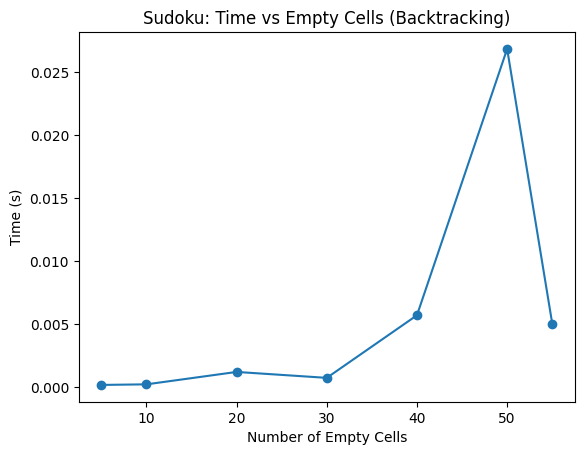

Saved -> images/sudoku_time_blanks.png


In [19]:
# === Cell 3.3: sudoku time vs blanks (generate table + plot) ===
def time_vs_blanks(solved_board):
    import random, copy
    base = copy.deepcopy(solved_board)
    blank_counts = [5,10,20,30,40,50,55]
    rows = []
    for blanks in blank_counts:
        b = copy.deepcopy(base)
        cells = [(i,j) for i in range(9) for j in range(9)]
        chosen = random.sample(cells, blanks)
        for (i,j) in chosen:
            b[i][j] = 0
        t0 = time.perf_counter()
        solve_sudoku(b)
        t1 = time.perf_counter()
        rows.append({"empty_cells": blanks, "time_s": t1-t0})
    df = pd.DataFrame(rows)
    df_to_csv_and_display(df, filename="tables/sudoku_time_vs_blanks.csv")
    fig, ax = plt.subplots()
    ax.plot(df["empty_cells"], df["time_s"], marker='o')
    ax.set_xlabel("Number of Empty Cells")
    ax.set_ylabel("Time (s)")
    ax.set_title("Sudoku: Time vs Empty Cells (Backtracking)")
    save_and_show_plot(fig, "images/sudoku_time_blanks.png")

if solved:
    time_vs_blanks(solved_board)

,password_length,charset_size,time_s,mem_mb
0,1,6,0.213384,0.0
1,2,6,0.078376,0.0
2,3,6,0.078038,0.0
3,4,6,0.081099,0.0


Saved table -> tables/bruteforce_scaling.csv


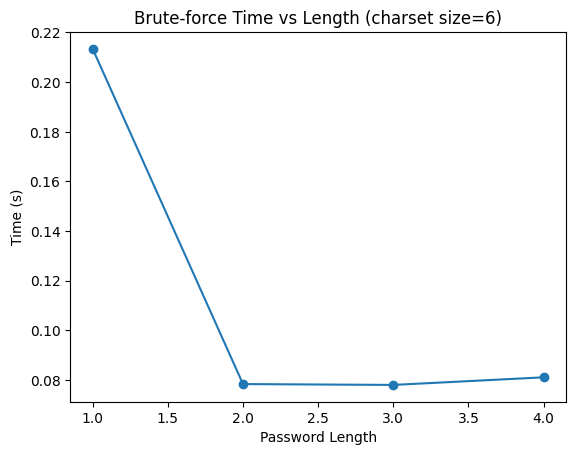

Saved -> images/bruteforce_time_len.png


In [20]:
# === Cell 4.1: brute_force_password + attempts table builder ===
def brute_force_password(target: str, charset: str, max_len: int = None, show_progress: bool=False):
    if max_len is None:
        max_len = len(target)
    attempts = 0
    t0 = time.perf_counter()
    for length in range(1, max_len + 1):
        for combo in itertools.product(charset, repeat=length):
            attempts += 1
            cand = ''.join(combo)
            if show_progress and attempts % 50000 == 0:
                print(f"Attempts: {attempts} -> trying {cand} ...")
            if cand == target:
                t1 = time.perf_counter()
                return {"found": cand, "attempts": attempts, "time": t1 - t0}
    t1 = time.perf_counter()
    return {"found": None, "attempts": attempts, "time": t1 - t0}

# helper to build table for time vs length
def brute_force_scaling_table(charset, lengths=[1,2,3,4]):
    rows = []
    for L in lengths:
        target = charset[0] * L
        mt = mem_and_time(lambda: brute_force_password(target, charset, max_len=L))
        rows.append({"password_length": L, "charset_size": len(charset), "time_s": mt["time"], "mem_mb": mt["mem_mb"]})
    df = pd.DataFrame(rows)
    df_to_csv_and_display(df, filename="tables/bruteforce_scaling.csv")
    fig, ax = plt.subplots()
    ax.plot(df["password_length"], df["time_s"], marker='o')
    ax.set_xlabel("Password Length")
    ax.set_ylabel("Time (s)")
    ax.set_title(f"Brute-force Time vs Length (charset size={len(charset)})")
    save_and_show_plot(fig, "images/bruteforce_time_len.png")

# Demo run with small charset
brute_force_scaling_table("abc123", lengths=[1,2,3,4])

In [21]:
# === Cell 5: quick summary of produced resources ===
print("Images created:")
for fname in sorted(os.listdir("images")):
    print(" - images/" + fname)
print("\nTables created:")
for fname in sorted(os.listdir("tables")):
    print(" - tables/" + fname)

Images created:
 - images/ads_vs_revenue.png
 - images/bruteforce_time_len.png
 - images/knapsack_budget_profit.png
 - images/sudoku_time_blanks.png

Tables created:
 - tables/ads_slots_example.csv
 - tables/ads_vs_revenue_table.csv
 - tables/bruteforce_scaling.csv
 - tables/knapsack_capacity_results.csv
 - tables/knapsack_dp_example.csv
 - tables/sudoku_solved_example.csv
 - tables/sudoku_time_vs_blanks.csv


## Presentation assets included
- All experiments save plots to `/images` and tables (CSV) to `/tables`.
- Use `tables/*.csv` to import into PowerPoint/Excel or present as tables.
- Use `/images/*.png` as slide figures (high DPI saved).
- Keep brute force and large DP capacities small for Colab demo runs.
